# 06 — Model Training (Hopsworks Feature Store)

This notebook trains forecasting models using the **engineered traffic features** plus **weather** and **TfL disruption** features stored in Hopsworks Feature Groups.

**Targets / labels** come from a separate Label Feature Group (generated in your label backfill notebook):
- `label_speed_ratio_t_plus_30`
- `label_speed_ratio_t_plus_60`

The notebook:
1. Logs into Hopsworks
2. Reads Feature Groups into pandas
3. Builds a training dataframe by joining on `(point_id, time)`
4. Trains one model per horizon (30m, 60m)
5. Saves artifacts (`.joblib` + JSON metadata)

In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import hopsworks



import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler


pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

C:\Users\omarl\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# -------------------------
# Hopsworks connection
# -------------------------
HOPSWORKS_HOST = os.getenv("HOPSWORKS_HOST", "")  # e.g. "eu-west.cloud.hopsworks.ai"
HOPSWORKS_PROJECT = os.getenv("HOPSWORKS_PROJECT", "")  # e.g. "London_traffic"
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY", "")  # recommended for non-interactive runs

# -------------------------
# Feature Group names/versions (defaults from your existing notebooks)
# -------------------------
# Feature View
FV_NAME = os.getenv("FV_NAME", "traffic_speed_ratio_fv")
FV_VERSION = int(os.getenv("FV_VERSION", "1"))

# Column names (adjust if your FV uses different names/prefixes)
POINT_ID_COL = os.getenv("POINT_ID_COL", "point_id")
TIME_COL = os.getenv("TIME_COL", "ts_10m")
LABEL_30_COL = os.getenv("LABEL_30_COL", "label_speed_ratio_t_plus_30")
LABEL_60_COL = os.getenv("LABEL_60_COL", "label_speed_ratio_t_plus_60")

# Optional batch window (if your HSFS requires it)
# Formats accepted by HSFS: YYYYMMDD, YYYYMMDDHH, YYYYMMDDHHMM, YYYYMMDDHHMMSS
BATCH_START_TIME = os.getenv("BATCH_START_TIME", "")  # e.g. "20260101000000"
BATCH_END_TIME = os.getenv("BATCH_END_TIME", "")      # e.g. "20260111235959"

ARTIFACT_DIR = Path(os.getenv("ARTIFACT_DIR", "artifacts"))
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

print("Config:")
print("Host:", HOPSWORKS_HOST)
print("Project:", HOPSWORKS_PROJECT)
print("FV:", FV_NAME, FV_VERSION)
print("Cols:", POINT_ID_COL, TIME_COL, LABEL_30_COL, LABEL_60_COL)
print("Batch window:", BATCH_START_TIME, "->", BATCH_END_TIME)

Config:
TRAFFIC: traffic_temporal_fg 1
WEATHER: weather_hourly_fg 1
TFL: tfl_disruptions_hourly_fg 1
LABELS: labels_speed_ratio_fg 1


In [3]:
project = hopsworks.login(host="eu-west.cloud.hopsworks.ai",
    project="London_traffic")
fs = project.get_feature_store()

print("Connected to feature store:", fs.name)


2026-01-11 07:27:25,654 INFO: Initializing external client
2026-01-11 07:27:25,655 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-11 07:27:27,333 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/3209
Connected to feature store: london_traffic_featurestore


In [4]:
traffic_fg = fs.get_feature_group(name=TRAFFIC_FG_NAME, version=TRAFFIC_FG_VERSION)
weather_fg = fs.get_feature_group(name=WEATHER_FG_NAME, version=WEATHER_FG_VERSION)
tfl_fg = fs.get_feature_group(name=TFL_FG_NAME, version=TFL_FG_VERSION)
label_fg = fs.get_feature_group(name=LABEL_FG_NAME, version=LABEL_FG_VERSION)

traffic_df = traffic_fg.read()
weather_df = weather_fg.read()
tfl_df = tfl_fg.read()
labels_df = label_fg.read()

print("traffic_df:", traffic_df.shape)
print("weather_df:", weather_df.shape)
print("tfl_df:", tfl_df.shape)
print("labels_df:", labels_df.shape)

traffic_df.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.25s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.75s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.77s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 
traffic_df: (26107, 33)
weather_df: (38400, 6)
tfl_df: (64645, 7)
labels_df: (25718, 4)


,timestamp_utc,point_id,frc,current_speed,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure,ts_10m,speed_ratio,delay_seconds,day_of_week,is_weekend,hour,minute,is_rush_hour,ti_evening_peak,ti_midday,ti_morning_peak,ti_night,speed_diff,travel_time_ratio,low_confidence_flag,speed_roll_mean_3,speed_roll_std_3,delay_roll_mean_3,speed_roll_mean_6,speed_roll_std_6,delay_roll_mean_6,speed_roll_mean_12,speed_roll_std_12,delay_roll_mean_12
0,2026-01-05 04:06:27.356994+00:00,37825,FRC2,24.0,24.0,209.0,209.0,1.0,False,2026-01-05 04:00:00+00:00,1.0,0.0,0,0,4,0,0,False,False,False,True,0.0,1.0,0,24.000000,0.000000,0.000000,24.000000,0.000000,0.0,23.833333,0.577350,0.833333
1,2026-01-06 06:29:30.303904+00:00,46818,FRC3,27.0,27.0,142.0,142.0,1.0,False,2026-01-06 06:20:00+00:00,1.0,0.0,1,0,6,20,0,False,False,False,True,0.0,1.0,0,27.000000,0.000000,0.000000,27.000000,0.000000,0.0,27.000000,0.000000,0.000000
2,2026-01-06 22:47:48.292950+00:00,17687,FRC3,30.0,30.0,136.0,136.0,1.0,False,2026-01-06 22:40:00+00:00,1.0,0.0,1,0,22,40,0,False,False,False,True,0.0,1.0,0,30.000000,0.000000,0.000000,30.000000,0.000000,0.0,30.000000,0.000000,0.000000
3,2026-01-07 03:50:03.489327+00:00,17524,FRC3,34.0,34.0,316.0,316.0,1.0,False,2026-01-07 03:50:00+00:00,1.0,0.0,2,0,3,50,0,False,False,False,True,0.0,1.0,0,34.000000,0.000000,0.000000,34.000000,0.000000,0.0,34.000000,0.000000,0.000000
4,2026-01-06 10:32:59.405332+00:00,38572,FRC3,23.0,23.0,60.0,60.0,1.0,False,2026-01-06 10:30:00+00:00,1.0,0.0,1,0,10,30,0,False,True,False,False,0.0,1.0,0,16.666667,6.027714,30.666667,18.166667,4.535049,21.0,18.250000,3.980064,19.416667


In [5]:
def _to_utc_dt(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, utc=True, errors="coerce")

traffic_df[TIME_COL] = _to_utc_dt(traffic_df[TIME_COL])
labels_df[TIME_COL] = _to_utc_dt(labels_df[TIME_COL])

# Weather/TfL time columns
if "weather_time_utc" in weather_df.columns:
    weather_df["weather_time_utc"] = _to_utc_dt(weather_df["weather_time_utc"])
if "tfl_time_utc" in tfl_df.columns:
    tfl_df["tfl_time_utc"] = _to_utc_dt(tfl_df["tfl_time_utc"])

# Deduplicate keys defensively
traffic_df = traffic_df.drop_duplicates(subset=[POINT_ID_COL, TIME_COL], keep="last")
labels_df = labels_df.drop_duplicates(subset=[POINT_ID_COL, TIME_COL], keep="last")

# Sort for time split
traffic_df = traffic_df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)
labels_df = labels_df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)

print("After cleaning:")
print("traffic_df:", traffic_df.shape)
print("labels_df:", labels_df.shape)


After cleaning:
traffic_df: (26107, 33)
labels_df: (25718, 4)


In [6]:
nan_counts = tfl_df.isna().sum()
nan_counts

point_id            0
tfl_time_utc        0
disruption_count    0
is_works            0
is_incident         0
is_active           0
max_ordinal         0
dtype: int64

In [7]:
# Build join times (hourly buckets for weather and TfL)
traffic_df["weather_time_utc"] = traffic_df[TIME_COL].dt.floor("H")
traffic_df["tfl_time_utc"] = traffic_df[TIME_COL].dt.floor("H")

# Join Weather
if "weather_time_utc" in weather_df.columns:
    df = traffic_df.merge(
        weather_df,
        on=[POINT_ID_COL, "weather_time_utc"],
        how="left",
        suffixes=("", "_w"),
    )
else:
    df = traffic_df.copy()

# Join TfL
if "tfl_time_utc" in tfl_df.columns:
    df = df.merge(
        tfl_df,
        on=[POINT_ID_COL, "tfl_time_utc"],
        how="left",
        suffixes=("", "_tfl"),
    )

# Join Labels (same 10-min bucket time)
df = df.merge(
    labels_df[[POINT_ID_COL, TIME_COL, LABEL_30_COL, LABEL_60_COL]],
    on=[POINT_ID_COL, TIME_COL],
    how="inner",  # training requires labels
)

print("Joined training df:", df.shape)
df.head()


Joined training df: (25718, 46)


,timestamp_utc,point_id,frc,current_speed,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure,ts_10m,speed_ratio,delay_seconds,day_of_week,is_weekend,hour,minute,is_rush_hour,ti_evening_peak,ti_midday,ti_morning_peak,ti_night,speed_diff,travel_time_ratio,low_confidence_flag,speed_roll_mean_3,speed_roll_std_3,delay_roll_mean_3,speed_roll_mean_6,speed_roll_std_6,delay_roll_mean_6,speed_roll_mean_12,speed_roll_std_12,delay_roll_mean_12,weather_time_utc,tfl_time_utc,temperature_2m,precipitation,rain,snowfall,disruption_count,is_works,is_incident,is_active,max_ordinal,label_speed_ratio_t_plus_30,label_speed_ratio_t_plus_60
0,2026-01-04 21:06:26.896088+00:00,16435,FRC3,17.0,18.0,291.0,275.0,0.928185,True,2026-01-04 21:00:00+00:00,0.944444,16.0,6,1,21,0,0,False,False,False,True,1.0,1.058182,0,17.000000,0.000000,16.000000,17.00,0.000000,16.0,17.00,0.000000,16.0,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.941176,0.944444
1,2026-01-04 21:16:26.877629+00:00,16435,FRC3,16.0,18.0,310.0,275.0,0.931579,True,2026-01-04 21:10:00+00:00,0.888889,35.0,6,1,21,10,0,False,False,False,True,2.0,1.127273,0,16.500000,0.707107,25.500000,16.50,0.707107,25.5,16.50,0.707107,25.5,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.777778,1.000000
2,2026-01-04 21:26:26.875416+00:00,16435,FRC3,18.0,18.0,275.0,275.0,0.937237,True,2026-01-04 21:20:00+00:00,1.000000,0.0,6,1,21,20,0,False,False,False,True,0.0,1.000000,0,17.000000,1.000000,17.000000,17.00,1.000000,17.0,17.00,1.000000,17.0,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.944444,1.000000
3,2026-01-04 21:36:26.873172+00:00,16435,FRC3,16.0,17.0,310.0,291.0,0.935823,True,2026-01-04 21:30:00+00:00,0.941176,19.0,6,1,21,30,0,False,False,False,True,1.0,1.065292,0,16.666667,1.154701,18.000000,16.75,0.957427,17.5,16.75,0.957427,17.5,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.944444,0.944444
4,2026-01-04 21:46:26.875794+00:00,16435,FRC3,14.0,18.0,354.0,275.0,0.935743,True,2026-01-04 21:40:00+00:00,0.777778,79.0,6,1,21,40,0,False,False,False,True,4.0,1.287273,0,16.000000,2.000000,32.666667,16.20,1.483240,29.8,16.20,1.483240,29.8,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.888889


In [8]:
# Identify candidate weather columns from your weather backfill config
possible_weather_cols = [
    "temperature_2m", "precipitation", "rain", "snowfall",
    "wind_speed_10m", "cloud_cover", "pressure_msl"
]
weather_df_cols=weather_df.columns.tolist()
weather_cols = [c for c in weather_df_cols if c in df.columns]

# Identify TfL columns from your TfL backfill
possible_tfl_cols = ["disruption_count", "is_works", "is_incident", "is_active", "max_ordinal"]
tfl_df_cols=tfl_df.columns.tolist()
tfl_cols = [c for c in tfl_df_cols if c in df.columns]

# --- IMPORTANT: ensure proper ordering for fills ---
df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True, errors="coerce")
df = df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)

# For weather: forward fill per point, then global median
for c in weather_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df.groupby(POINT_ID_COL)[c].ffill().bfill()
    med = float(df[c].median()) if df[c].notna().any() else 0.0
    df[c] = df[c].fillna(med)

# Rationale: TfL is hourly; after merging into 10-min grid, we want the last known hourly state
for c in tfl_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df.groupby(POINT_ID_COL)[c].ffill()

    #if early rows still NaN (no prior hour available), fallback to 0
    df[c] = df[c].fillna(0.0)

# Labels sanity
for c in [LABEL_30_COL, LABEL_60_COL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[LABEL_30_COL, LABEL_60_COL]).reset_index(drop=True)

print("After NA handling:", df.shape)


After NA handling: (25718, 46)


In [9]:
# Exclude non-feature columns
exclude_cols = {
    TIME_COL,
    "timestamp_utc",  # if present
    "weather_time_utc",
    "tfl_time_utc",
    LABEL_30_COL,
    LABEL_60_COL,
}

# Keep only numeric columns as model features
feature_cols = []
for c in df.columns:
    if c in exclude_cols:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        feature_cols.append(c)

print("Number of candidate feature columns:", len(feature_cols))
feature_cols[:30]


Number of candidate feature columns: 39


['point_id',
 'current_speed',
 'free_flow_speed',
 'current_travel_time',
 'free_flow_travel_time',
 'confidence',
 'road_closure',
 'speed_ratio',
 'delay_seconds',
 'day_of_week',
 'is_weekend',
 'hour',
 'minute',
 'is_rush_hour',
 'ti_evening_peak',
 'ti_midday',
 'ti_morning_peak',
 'ti_night',
 'speed_diff',
 'travel_time_ratio',
 'low_confidence_flag',
 'speed_roll_mean_3',
 'speed_roll_std_3',
 'delay_roll_mean_3',
 'speed_roll_mean_6',
 'speed_roll_std_6',
 'delay_roll_mean_6',
 'speed_roll_mean_12',
 'speed_roll_std_12',
 'delay_roll_mean_12']

In [10]:
df_sorted = df.sort_values(TIME_COL).reset_index(drop=True)

TEST_FRACTION = 0.2
VAL_FRACTION = 0.1

n = len(df_sorted)
cut_test = int(round(n * (1 - TEST_FRACTION)))
train_full = df_sorted.iloc[:cut_test].copy()
test_df = df_sorted.iloc[cut_test:].copy()

n_tr = len(train_full)
cut_val = int(round(n_tr * (1 - VAL_FRACTION)))
train_df = train_full.iloc[:cut_val].copy()
val_df = train_full.iloc[cut_val:].copy()

X_train = train_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
X_val   = val_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
X_test  = test_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()

y_train = train_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()
y_val   = val_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()
y_test  = test_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()

print(X_train.shape, y_train.shape)


(18517, 39) (18517, 2)


In [31]:
# -------------------------
# Scale numeric features (fit on TRAIN only)
# -------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)
y_test  = y_test.astype(np.float32)


print("Dtypes:", X_train.dtype, y_train.dtype)
print("Finite X:", np.isfinite(X_train).all(), "Finite y:", np.isfinite(y_train).all())


Dtypes: float32 float32
Finite X: True Finite y: True


In [136]:
# -------------------------
# Build Keras model (numeric trunk + point_id embedding)
# -------------------------

tf.keras.utils.set_random_seed(42)

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(2, activation="linear"), 
])


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="mse",
    metrics=[keras.metrics.MeanSquaredError(name="mse"),
        keras.metrics.MeanAbsoluteError(name="mae"),
             keras.metrics.RootMeanSquaredError(name="rmse")]
)

model.summary()


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_172 (Dense)               │ (None, 256)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,050 (211.13 KB)

 Trainable params: 53,794 (210.13 KB)

 Non-trainable params: 256 (1.00 KB)

In [137]:
# -------------------------
# Train with early stopping
# -------------------------


callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6),
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


print("Best val_loss:", float(np.min(history.history["val_loss"])))


Epoch 1/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9081 - mae: 0.7250 - mse: 0.9081 - rmse: 0.9530 - val_loss: 0.5056 - val_mae: 0.6899 - val_mse: 0.5056 - val_rmse: 0.7110 - learning_rate: 3.0000e-04
Epoch 2/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3861 - mae: 0.4798 - mse: 0.3861 - rmse: 0.6214 - val_loss: 0.3919 - val_mae: 0.6042 - val_mse: 0.3919 - val_rmse: 0.6260 - learning_rate: 3.0000e-04
Epoch 3/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2648 - mae: 0.4024 - mse: 0.2648 - rmse: 0.5146 - val_loss: 0.2534 - val_mae: 0.4790 - val_mse: 0.2534 - val_rmse: 0.5034 - learning_rate: 3.0000e-04
Epoch 4/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2024 - mae: 0.3528 - mse: 0.2024 - rmse: 0.4499 - val_loss: 0.1679 - val_mae: 0.3814 - val_mse: 0.1679 - val_rmse: 0.4097 - learning_rate: 3.0000e-04
Epoch 5/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1673 - mae: 0.3223 - mse: 0.1673 - rmse: 0.4091 - val_loss: 0.1154 - val_mae: 0.3091 - val

In [138]:
# -------------------------
# Evaluate on TEST (report in speed_ratio space)
# -------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pred= model.predict(X_test)


def eval_one(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2= r2_score(y_true, y_pred)
    return {"mse": mse, "mae": mae, "rmse": rmse, "r2": r2}

eval_30 = eval_one(y_test[:, 0], pred[:, 0])
eval_60 = eval_one(y_test[:, 1], pred[:, 1])
print("Evaluation on TEST set:")
print(" t+30:", eval_30)
print(" t+60:", eval_60)

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
Evaluation on TEST set:
 t+30: {'mse': 0.016150905, 'mae': 0.100083776, 'rmse': 0.1270862, 'r2': 0.5071434082683128}
 t+60: {'mse': 0.016461639, 'mae': 0.10149921, 'rmse': 0.12830292, 'r2': 0.4749315745127879}


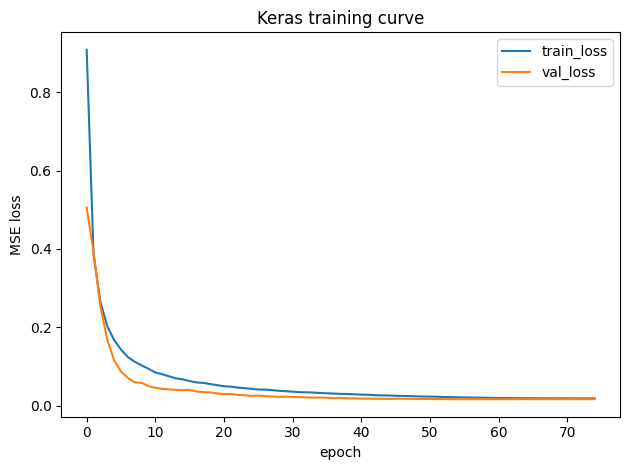

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


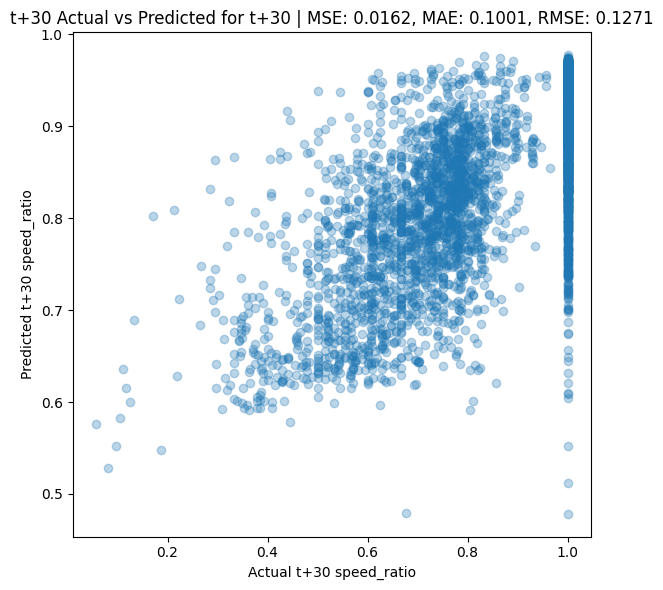

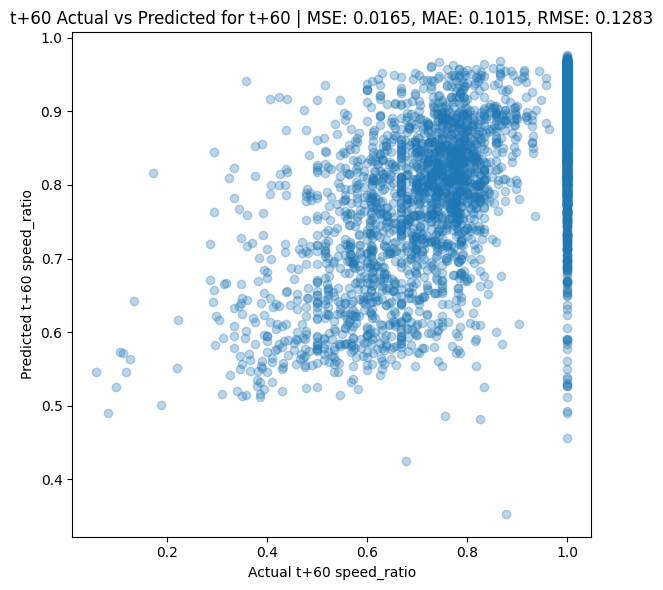

In [139]:
# -------------------------
# Plots: training curves + scatter
# -------------------------
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Keras training curve")
plt.legend()
plt.tight_layout()
plt.show()

y_pred=model.predict(X_test)

for j, name in [(0, "t+30"), (1, "t+60")]:
    mse, mae, rmse,r2 = eval_one(y_test[:, j], y_pred[:, j]).values()
    plt.figure(figsize=(6,6))
    plt.scatter(y_test[:, j], y_pred[:, j], alpha=0.3)
    plt.xlabel(f'Actual {name} speed_ratio')
    plt.ylabel(f'Predicted {name} speed_ratio')
    plt.title(f'{name} Actual vs Predicted for {name} | MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    plt.tight_layout()
    plt.show()
